In [1]:
import math
import warnings

from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

In [27]:
NY_2013_raw = pd.read_csv('https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/New_York_offenses/NEW_YORK-Offenses_Known_to_Law_Enforcement_by_City_2013%20-%2013tbl8ny.csv',
                      skiprows=[0,1,2,3])
NY_2013_raw.columns =['city',
                   'population',
                   'violent_crime',
                   'murder',
                   'rape_def_1',
                   'rape_def_2',
                  'robbery',
                  'aggravated_assault',
                  'property_crime',
                  'burglary',
                  'larceny_theft',
                  'motor_vehicle_theft',
                  'arson']

In [90]:
#set dataframe with features to try out
NY_2013 = NY_2013_raw[['population','violent_crime','murder','rape_def_2',
                       'robbery','aggravated_assault','property_crime']].copy()
NY_2013 = NY_2013.dropna()

#remove all commas
cols = ['population','violent_crime','murder','rape_def_2',
        'robbery','aggravated_assault','property_crime']
NY_2013[cols] = NY_2013[cols].replace({',':''}, regex=True)

#cast to int
NY_2013[cols] = NY_2013[cols].astype(int)

#remove outliers using 3 std dvs
#NY_2013 = NY_2013[np.abs(NY_2013 - NY_2013.mean()) <= (3 * NY_2013.std())]
#NY_2013 = NY_2013.dropna()
#NY_2013[cols] = NY_2013[cols].astype(int)

NY_2013.head()

,population,violent_crime,murder,rape_def_2,robbery,aggravated_assault,property_crime
0,1861,0,0,0,0,0,12
1,2577,3,0,0,0,3,24
2,2846,3,0,0,0,3,16
3,97956,791,8,30,227,526,4090
4,6388,23,0,3,4,16,223


In [91]:
regr = linear_model.LinearRegression()
y_NY_2013 = NY_2013['property_crime'].values.reshape(-1,1)
X_NY_2013 = NY_2013[['population','murder','rape_def_2',
                     'robbery','aggravated_assault']]
regr.fit(X_NY_2013,y_NY_2013)

print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X_NY_2013, y_NY_2013))
print('\nAdjusted R-squared: \n',
      1 - (1-regr.score(X_NY_2013,y_NY_2013))*(len(y_NY_2013)-1)/(len(y_NY_2013) - X_NY_2013.shape[1]-1))


Coefficients: 
 [[ 1.21189893e-02  7.48268123e+01  6.12845922e+01 -5.63689035e-01
  -1.32770779e+00]]

Intercept: 
 [32.86846523]

R-squared:
0.9990024878038867

Adjusted R-squared: 
 0.9989879042922476


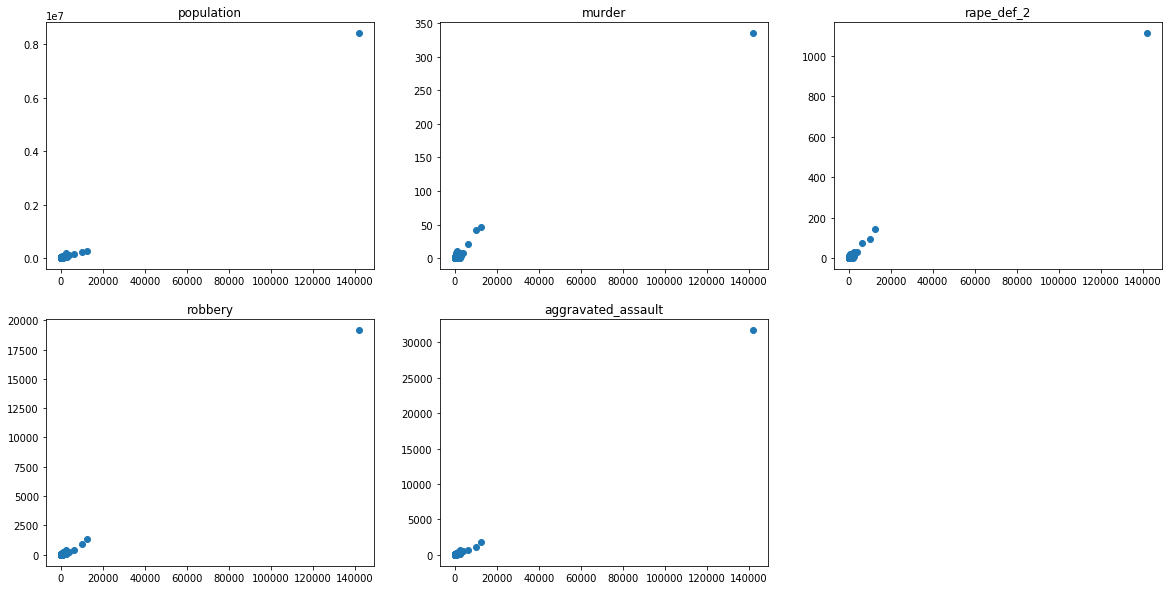

In [92]:
#check features for linearity
plt.figure(figsize=(20,10))

plt.subplot(2,3,1)
plt.scatter(y_NY_2013,NY_2013['population'])
plt.title('population')

plt.subplot(2,3,2)
plt.scatter(y_NY_2013,NY_2013['murder'])
plt.title('murder')

plt.subplot(2,3,3)
plt.scatter(y_NY_2013,NY_2013['rape_def_2'])
plt.title('rape_def_2')

plt.subplot(2,3,4)
plt.scatter(y_NY_2013,NY_2013['robbery'])
plt.title('robbery')

plt.subplot(2,3,5)
plt.scatter(y_NY_2013,NY_2013['aggravated_assault'])
plt.title('aggravated_assault')

plt.show()

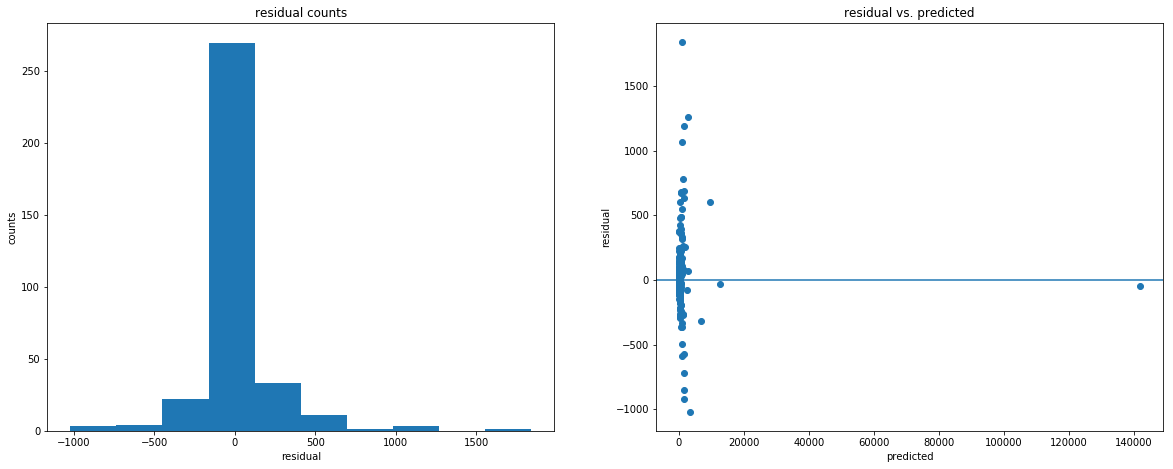

In [93]:
#check for error normality and homoscedasticity
NY_2013_predicted = regr.predict(X_NY_2013).ravel()
NY_2013_actual = NY_2013['property_crime']
NY_2013_residual = NY_2013_actual - NY_2013_predicted

plt.figure(figsize=(20,7.5))

plt.subplot(1,2,1)
plt.hist(NY_2013_residual)
plt.title('residual counts')
plt.xlabel('residual')
plt.ylabel('counts')

plt.subplot(1,2,2)
plt.scatter(NY_2013_predicted,NY_2013_residual)
plt.axhline(y=0)
plt.xlabel('predicted')
plt.ylabel('residual')
plt.title('residual vs. predicted')

plt.show()

In [94]:
correlation_matrix = X_NY_2013.corr()
display(correlation_matrix)

,population,murder,rape_def_2,robbery,aggravated_assault
population,1.000,0.987,0.991,0.998,0.999
murder,0.987,1.000,0.998,0.993,0.991
rape_def_2,0.991,0.998,1.000,0.995,0.994
robbery,0.998,0.993,0.995,1.000,1.000
aggravated_assault,0.999,0.991,0.994,1.000,1.000


In [101]:
linear_formula = 'property_crime ~ population+murder+rape_def_2+robbery+aggravated_assault'
lm_NY_2013 = smf.ols(formula=linear_formula, data=NY_2013).fit()

lm_NY_2013.params

Intercept            32.868
population            0.012
murder               74.827
rape_def_2           61.285
robbery              -0.564
aggravated_assault   -1.328
dtype: float64

In [102]:
lm_NY_2013.pvalues

Intercept            0.043
population           0.000
murder               0.000
rape_def_2           0.000
robbery              0.583
aggravated_assault   0.028
dtype: float64

In [103]:
lm_NY_2013.rsquared

0.9990024878038868

In [110]:
lm_NY_2013.conf_int()

,0,1
Intercept,0.995,64.742
population,0.010,0.014
murder,44.120,105.533
rape_def_2,52.884,69.685
robbery,-2.579,1.451
aggravated_assault,-2.510,-0.146


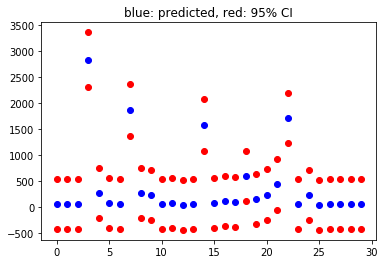

In [113]:
# Use wls_prediction_std to build confidence intervals
prstd, iv_l, iv_u = wls_prediction_std(lm_NY_2013)

plt.figure()
plt.plot(iv_u[0:30], 'o', color='r')
plt.plot(iv_l[0:30], 'o', color='r')
plt.plot(lm_NY_2013.fittedvalues[0:30], 'o', color='b')
plt.title('blue: predicted, red: 95% CI')
plt.show()

## Regression 2

In [105]:
#robbery pvalue high, drop
linear_formula_2 = 'property_crime ~ population+murder+rape_def_2+aggravated_assault'
lm_NY_2013_2 = smf.ols(formula=linear_formula_2, data=NY_2013).fit()

lm_NY_2013_2.params

Intercept            33.901
population            0.012
murder               68.791
rape_def_2           61.951
aggravated_assault   -1.620
dtype: float64

In [106]:
lm_NY_2013_2.pvalues

Intercept            0.036
population           0.000
murder               0.000
rape_def_2           0.000
aggravated_assault   0.000
dtype: float64

In [107]:
lm_NY_2013_2.rsquared

0.9990016046992483

In [109]:
lm_NY_2013_2.conf_int()

,0,1
Intercept,2.275,65.528
population,0.010,0.014
murder,46.963,90.620
rape_def_2,53.903,69.998
aggravated_assault,-2.170,-1.071


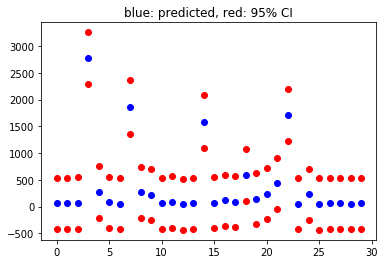

In [112]:
# Use wls_prediction_std to build confidence intervals
prstd, iv_l, iv_u = wls_prediction_std(lm_NY_2013_2)

plt.figure()
plt.plot(iv_u[0:30], 'o', color='r')
plt.plot(iv_l[0:30], 'o', color='r')
plt.plot(lm_NY_2013_2.fittedvalues[0:30], 'o', color='b')
plt.title('blue: predicted, red: 95% CI')
plt.show()

## Regression 3

In [114]:
linear_formula_3 = 'property_crime ~ population+murder+robbery'
lm_NY_2013_3= smf.ols(formula=linear_formula_3, data=NY_2013).fit()

lm_NY_2013_3.params

Intercept     87.066
population     0.012
murder       228.489
robbery       -1.924
dtype: float64

In [115]:
lm_NY_2013_3.pvalues

Intercept    0.000
population   0.000
murder       0.000
robbery      0.002
dtype: float64

In [116]:
lm_NY_2013_3.rsquared

0.9983708205913115

In [117]:
lm_NY_2013_3.conf_int()

,0,1
Intercept,47.830,126.302
population,0.010,0.014
murder,205.624,251.355
robbery,-3.114,-0.734


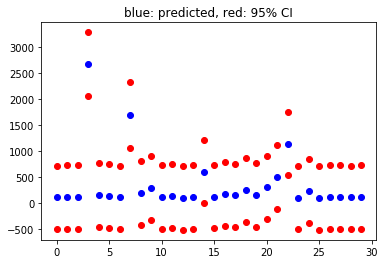

In [119]:
# Use wls_prediction_std to build confidence intervals
prstd, iv_l, iv_u = wls_prediction_std(lm_NY_2013_3)

plt.figure()
plt.plot(iv_u[0:30], 'o', color='r')
plt.plot(iv_l[0:30], 'o', color='r')
plt.plot(lm_NY_2013_3.fittedvalues[0:30], 'o', color='b')
plt.title('blue: predicted, red: 95% CI')
plt.show()